# Data Analysis

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
pathtohere = Path()

In [2]:
LHC_s = (7e+3)**2 # [GeV^2] 

fineStructure = 1. / 137.035999206 # https://www.nature.com/articles/s41586-020-2964-7
# https://academic.oup.com/ptep/article/2022/8/083C01/6651666?login=false
CKM = np.asarray([[0.97373, 0.2243, 0.00382], [0.221, 0.975, 0.0408], [0.0086, 0.0415, 1.014]]) 
fermiConstant = 1.1663788e-5 # [GeV^-2] # https://arxiv.org/abs/1010.0991
sin2WeinbergAngle = 0.23142 # https://arxiv.org/abs/1509.07645

BR_W_enu = 0.1083 # https://arxiv.org/abs/2201.07861
BR_Z_ee  = 0.03363 # https://pdg.lbl.gov/2009/tables/rpp2009-sum-gauge-higgs-bosons.pdf

In [3]:
def read_parameterFile():
    """
    Read variables from parameter file and extract useful quantities.
    
    Outputs:
        - LHC_s:float: CoM squared energy.
        - m_W:float: Mass of W boson used.
        - m_Z:float: Mass of Z boson used.
        - Qs:np.ndarray: Q^2 values used.
    """
    
    with open(pathtohere / 'data/parameterFile.txt') as f:
        while line:=f.readline():
            thisLine = line.rstrip().split(' ')
            if thisLine[0]=='s':
                LHC_s = float(thisLine[-1])
            elif thisLine[0]=='m_W':
                m_W = float(thisLine[-1])
            elif thisLine[0]=='m_Z':
                m_Z = float(thisLine[-1])
            elif thisLine[0]=='Qmin':
                Qmin = float(thisLine[-1])
            elif thisLine[0]=='Qmax':
                Qmax = float(thisLine[-1])
            elif thisLine[0]=='numQ':
                numQ = int(thisLine[-1])
                
    Qs = np.linspace(Qmin, Qmax, numQ)
    
    return LHC_s,m_W,m_Z,Qs
                


def read_data(file:str, m_W:float, m_Z:float, Qs:np.ndarray):
    """
    Read a given data file.
    
    Inputs:
        - file:str: Filename.
        - m_W:float: Mass of W boson used.
        - m_Z:float: Mass of Z boson used.
        - Qs:np.ndarray: Q^2 values used.
        
    Outputs:
        - xs:np.ndarray: Momentum fractions.
        - data:np.ndarray: PDFs. (Q^2,x,flavour)
        - qs:np.ndarray: Q^2 used.
    """
    
    # Get data from file for x1.
    data_all = np.loadtxt(pathtohere / file, dtype=str)
    whereNan = np.where('-nan(ind)'==data_all)
    data_all[whereNan] = '0.'
    data_all = data_all.astype(float)
    
    # Split into different Q^2
    qs = np.concatenate((np.asarray([m_W,m_Z]), Qs))
    numQ = int(qs.shape[0])
    numX = int(data_all.shape[0]/numQ)
    data = np.empty((numQ,numX,data_all.shape[1]),dtype=float)
    for i in range(numQ):
        data[i,:,:] = data_all[i*numX:(i+1)*numX]
        
    xs = data[:,:,0]

    
    data = data[:,:,1:]
    
    return xs, data, qs


In [4]:
def display_PDFs(xs:np.ndarray, data:np.ndarray, headings:tuple,colours:tuple,q:float, momFrac:int):
    """
    Display the PDFs.
    
    Inputs:
        - xs:np.ndarray: Momentum fractions the PDFs are evaluated at.
        - data:np.ndarray: 2D array of PDFs of each used quark at all x.
        - headings:tuple: Quark types used.
        - colours:tuple: Graph colours.
        - q:float: Q evaluated at.
        - momFrac:int: Momentum fraction index 1/2.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    divider = 1.
    
    for i,heading in enumerate(headings):
        if '/' in heading:
            divider = float(heading.split('/')[1])
        ax.plot(xs, data[:, i] / divider, label=heading,c=colours[i],marker='.')
        ax.grid()
    
    # Create appropiate labels.
    ax.set_xlabel(f'momentum fraction / x_{momFrac}')
    ax.set_ylabel(r'PDF / $f_i(x)$')
    ax.set_title(r'$Q$ =' + str(q))
    
    ax.legend(loc='best')
    ax.set_xscale('log')
    
    plt.show()
    
    
    
def display_fortran_c_error(data_c:np.ndarray, data_f:np.ndarray,
                            xs:np.ndarray,headings:tuple,colours:tuple,
                           q2:float):
    """
    Error of C translated code to Fortran (hopefully zero).
    
    Inputs:
        - data_c:np.ndarray: Data obtained from C++ code.
        - data_f:np.ndarray: Data obtained from Fortran code.
        - xs:np.ndarray: Momentum fraction evaluated at.
        - headings:tuple: Quark types used.
        - colours:tuple: Graph colours.
        - qs:float: Q^2 evaluated at.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    
    for i,heading in enumerate(headings):
        ax.plot(xs, data_c[:, i] - data_f[:,i], label=heading,c=colours[i],marker='.')
        ax.grid()
        
    ax.axhspan(-1e-6, 1e-6,
                    alpha=0.2, color='r')
    
    # Create appropiate labels.
    ax.set_xlabel('momentum fraction / x')
    ax.set_ylabel(r'PDF difference / $\Delta f_i(x)$')
    ax.set_title(r'$Q^2$ =' + str(q2))
    
    ax.legend(loc='best')
    ax.set_xscale('log')
    
    plt.show()

### Cross section calculations
Using $x_2 = \frac{M^2}{sx_1}$, $y = \frac{1}{2}\ln\Big(\frac{x_1}{x_2}\Big)$, $\tilde{f}_q(x_i) = x_if_q(x_i)$

#### $\gamma$
$$
\sigma_{\gamma} = \int dM^2 \int dy\frac{4\pi\alpha^2}{3M^2}\frac{1}{Ns} \sum\limits_{q}\frac{Q^2_q}{x_1x_2} \Big(\tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2) + \tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2)\Big)
$$
#### W
$$
\sigma_W = \int dy \frac{\pi}{Ns}\sqrt{2}G_F|M_W^2||V_{q\bar{q}}|^2\frac{1}{x_1x_2} \sum\limits_{q_1}\sum\limits_{q_2}\Big(\tilde{f}_{q_1}(x_1)\tilde{f}_{\bar{q_2}}(x_2) + \tilde{f}_{q_1}(x_1)\tilde{f}_{\bar{q_2}}(x_2)\Big)
$$
#### Z
$$
\sigma_Z = \int dy \frac{\pi}{Ns}\sqrt{2}G_F|M_Z^2|(|V_{q\bar{q}}|^2 + |A_q|^2) \frac{1}{x_1x_2}\sum\limits_{q}\Big(\tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2) + \tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2)\Big)
$$

$$
\cos\theta = \frac{e^{2y_Z} - 1}{e^{2y_Z} + 1}
$$
$$
\frac{dy}{d\cos\theta} = \frac{1+\cos^2\theta}{2(1-\cos\theta)(1+\cos\theta)}
$$
$$
\frac{d\cos\theta}{dy} = 2e^{2y}\frac{2}{(e^{2y}+1)^2}
$$

$$
p_T = \frac{M_W}{2}\sqrt{1 - \cos^2\theta}
$$
$$
\frac{d\cos\theta}{dp_T} = -\frac{4p_T}{M_W^2}(1-\frac{4p_T^2}{M_W^2})^{-\frac{1}{2}}
$$


$$
y^* = \frac{1}{2}\ln\Big( \frac{1+\cos\theta}{1 - \cos\theta} \Big) \,\,;\, \theta\in[0,\pi)
$$
$$
y_e = y_W + y^*
$$

$$
\frac{d\sigma}{dy_e} = \int dy_W \frac{d\sigma}{dy_W} (y_W+y^*)
$$

In [8]:
class CrossSection:
    numUpType = 2
    upCharge = 2. / 3.
    numDownType = 3
    downCharge = -1./3.
    numColours:int = 3
    
    upType_i = slice(0,2)
    downType_i = slice(2,5)
    upTypeBar_i = slice(5,7)
    downTypeBar_i = slice(7,10)
    
    
    
    def __init__(self, WmassSqrd:float, ZmassSqrd:float,
                 data1:np.ndarray, data2:np.ndarray,x1:np.ndarray,
                 x2s:np.ndarray,qs:np.ndarray,W_index:int,
                 Z_index:int):
        """
        Initialise the class.
        
        Inputs:
            - WmassSqrd:float: Squared mass of the W boson.
            - ZmassSqrd:float: Squared mass of the Z boson.
            - data1:np.ndarray: PDFS associated with x1 (Q, x, PDF).
            - data2:np.ndarray: PDFS associated with x2 (Q, x, PDF).
            - x1:np.ndarray: Momentum fractions for proton 1.
            - x2s:np.ndarray: Momentum fractions for proton 2 at all Q.
            - qs:np.ndarray: Qs evaluated at.
            - W_index:int: Index of data for the W boson Q.
            - Z_index:int: Index of data for the Z boson Q.
        """
                 
        self.WmassSqrd = WmassSqrd
        self.ZmassSqrd = ZmassSqrd
        self.data = np.asarray((data1,data2))
        self.x1 = x1
        self.x2s = x2s
        self.numX = x1.shape[0]
        self.qs = qs[2:]
        self.numQ = qs.shape[0] - 2
        self.W_index = W_index
        self.Z_index = Z_index
        self.sigma0 = 4.*np.pi*fineStructure*fineStructure / (3.*qs*qs)
        
        self.photon_dydm = None
        self.photon_dm = None
        self.W_dy = {
            '+' : None,
            '-' : None
        }
        self.Z_dy = None
        self.W = {
            '+' : None,
            '-' : None
        }
        self.Z = None
        self.W_dcostheta = {
            '+' : None,
            '-' : None
        }        
        self.W_dpTe = {
            '+' : None,
            '-' : None
        }
        
        self.W_dy_e = {
            '+' : None,
            '-' : None
        }
        
### Internal #########################################################
    @staticmethod
    def _ytocos(y:np.ndarray):
        """
        Transforms a variable in rapidity to one in cos theta.
        
        Inputs:
            - y:np.ndarray: Data points in rapidity.
            
        Outputs:
            - cos:np.ndarray: Data points in cos theta.
        
        """

        return (np.exp(2.*y) - 1.) / (np.exp(2.*y) + 1.)
    
    @staticmethod
    def _dy_dcos(cos:np.ndarray):
        """
        Jacobian of transforming rapidity to cos theta (dy/dcostheta).
        
        Inputs:
            - cos:np.ndarray: Data in cos theta.
            
        Outputs:
            - dy_dcos:np.ndarray: Jacobian.
        
        """

        return (1. + cos*cos) / (2.*(1 - cos)*(1 + cos))
    
    @staticmethod
    def _dcos_dy(y:np.ndarray):
        """
        Jacobian of transforming cos theta to rapidity (dcostheta/dy).
        
        Inputs:
            - y:np.ndarray: Data in rapidity.
            
        Outputs:
            - dcos_dy:np.ndarray: Jacobian.
        """
        
        exp_y = np.exp(2*y)
        
        return 2*exp_y * 2 / (exp_y + 1) / (exp_y + 1)


    @staticmethod
    def _costopt(y:np.ndarray, massSqrd:float):
        """
        Transforms a variable in cos theta to one in missing transverse momentum.
        
        Inputs:
            - cos:np.ndarray: Data points in cos theta.
            - massSqrd:float: Mass squared of boson produced.
            
        Outputs:
            - pt:np.ndarray: Data points in missing transverse momentum.
        """

        return np.sqrt(massSqrd) / 2. * np.sqrt(1. - y*y)
    
    @staticmethod
    def _dcos_dpt(pt:np.ndarray, massSqrd:float):
        """
        Jacobian of transforming cos theta to missing transverse momentum (dcostheta/dpt).
        
        Inputs:
            - pt:np.ndarray: Data in missing transverse momentum.
            - massSqrd:float: Mass squared of boson produced.
            
        Outputs:
            - dcos_dpt:np.ndarray: Jacobian.
        
        """

        return 4.*pt/massSqrd / np.sqrt(1. - 4.*pt*pt/massSqrd)
    
    def _getCuts(self,cutType:str, lowerCut:float,
                 upperCut:float, rapidities:np.ndarray,massSqrd:float):
        """
        
        Inputs:
            - cutType:str: Variable to perform cuts on.
            - lowerCut:float: Lower bound of cut.
            - upperCut:float: Upper bound of cut.
            - rapidities:float: The rapidities.
            - massSqrd:float: Boson mass squared.
        
        Outputs:
            - whereInclude:np.ndarray: What variables to include in the cut.
        """
        
        theOnes = np.ones(self.numX,dtype=bool)
        
        # Implement cuts.
        if cutType is None:
            whereInclude = theOnes
        elif cutType=='rapidity':
            includeLower = rapidities>lowerCut if lowerCut is not None else theOnes
            includeUpper = rapidities<upperCut if upperCut is not None else theOnes
            whereInclude = includeLower & includeUpper
            jacobian = 1.
        elif cutType=='cos' or cutType=='pt':
            variableToCut = self._ytocos(rapidities)
            if cutType=='pt':
                variableToCut = self._costopt(variableToCut, massSqrd)
                
            includeLower = variableToCut>lowerCut if lowerCut is not None else theOnes
            includeUpper = variableToCut<upperCut if upperCut is not None else theOnes
            whereInclude = includeLower & includeUpper
            
        
        else:
            raise Exception('Invalid cut variable, must be one of: rapidity, cos, pt.')
            
        return whereInclude

    
    def calculate_cutRatioDependence(self, boson:str):
        """
        Calculate the cross-section ratio as the cut on the pt distribution is
        varied.
        
        Inputs:
            - boson:str: Boson being analysed.
        
        Outputs:
            - ptCuts:np.ndarray: Cuts applied to the pt distribution.
            - cs_ratios:np.ndarray: Cross-section ratio to the uncut cross-section.
        """
        
        assert boson in ('W+','W-','Z')
        i = np.argwhere(boson==np.asarray(('W+','W-','Z')))[0,0]
        
        numSamples = 10
        ptCuts = np.linspace(0,np.sqrt(self.WmassSqrd)/2., numSamples)
        cs_ratios = np.empty(numSamples)
        
        for j in range(numSamples):
            if i==2:
                self.calculate_Z(cutType='pt', lowerCut=ptCuts[j])
            else:
                self.calculate_W(Wcharge=boson[-1],cutType='pt', lowerCut=ptCuts[j])
                
            cs_ratios[j] = (self.W['+'],self.W['-'],self.Z)[i]
            
        cs_ratios /= cs_ratios[0]
        
        return ptCuts, cs_ratios

        
        

    
### W stuff #####################################################################
    def calculate_W_dy(self, Wcharge:str):
        """
        Calculate the W boson contribution to the cross-section.
        
        Inputs:
            - Wcharge:str: W boson charge to calculate (+/-).
        """
        
        assert Wcharge in {'+','-'}, "Wcharge must be one of {'+','-'}."

        upTypePDFs = self.data[:,self.W_index,:,self.upType_i]
        downTypePDFs = self.data[:,self.W_index,:,self.downType_i]
        upTypeBarPDFs = self.data[:,self.W_index,:,self.upTypeBar_i]
        downTypeBarPDFs = self.data[:,self.W_index,:,self.downTypeBar_i]
        
        
        W_dy = np.zeros(self.numX)
        for i in range(self.numUpType):
            for j in range(self.numDownType):
                poisson = np.zeros(self.numX)
                for k in range(2):
                    if Wcharge=='+':
                        poisson += upTypePDFs[k,:,i] * downTypeBarPDFs[1-k,:,j]

                    else:
                        poisson += upTypeBarPDFs[k,:,i] * downTypePDFs[1-k,:,j]

                W_dy += CKM[i,j]*CKM[i,j] * poisson

        W_dy *= np.pi/self.numColours*np.sqrt(2.) * fermiConstant*self.WmassSqrd
        W_dy /= LHC_s
        W_dy /= self.x1*self.x2s[self.W_index]
        W_dy *= 1e+9*0.3894 # [GeV^-2 -> pb]
        W_dy *= BR_W_enu
        
        self.W_dy[Wcharge] = W_dy



    def calculate_W(self, Wcharge:str, cutType:str=None, lowerCut:float=None, upperCut:float=None):
        """
        Integrate W contribution over rapidity.
        
        Inputs:
            - Wcharge:str: W boson charge to integrate.
            - cutType:str: Variable to perform cuts on.
            - lowerCut:float: Lower bound of cut.
            - upperCut:float: Upper bound of cut.
        """
        
        assert Wcharge in {'+','-'}, "Wcharge must be one of {'+','-'}."

        
        self.rapidities_W = 0.5 * np.log(self.x1 / self.x2s[self.W_index])

        whereInclude = self._getCuts(cutType, lowerCut,
                 upperCut, self.rapidities_W, self.WmassSqrd)

            
        if self.W_dy[Wcharge] is None:
            self.calculate_W_dy(Wcharge)
        

        # Determine active changes.
        splits = [0]
        prev = whereInclude[0]

        for i in range(1,self.numX):
            if whereInclude[i] != prev:
                prev = whereInclude[i]
                splits.append(i)
                
        splits.append(self.numX)
                
        
        # Integrate over rapidity.
        self.W[Wcharge] = 0.
        for i in range(len(splits)-1):
            if not whereInclude[splits[i]]:
                continue
            binRange = slice(splits[i],splits[i+1])
            self.W[Wcharge] += np.sum((self.W_dy[Wcharge][binRange][:-1] + self.W_dy[Wcharge][binRange][1:])
                            *(self.rapidities_W[binRange][1:] - self.rapidities_W[binRange][:-1]) / 2.)
        
    
    
    def calculate_W_dcostheta(self,Wcharge:str):
        """
        Calculate the differential dependence of the cross-section of the
        angle of the emitted electron in the W frame.
        
        Inputs:
            - Wcharge:str: W boson charge to integrate.
        """
        
        assert Wcharge in {'+','-'}, "Wcharge must be one of {'+','-'}."
        
        if self.W is None:
            self.calculate_W()
            
        self.thetas = np.linspace(0,np.pi,100)
            
        self.W_dcostheta = self.W[Wcharge] * 3/8 * (1 + np.cos(self.thetas)**2)
        
    def calculate_W_dpTe(self, Wcharge:str):
        """
        Calculate the differential dependence of the cross-section of the
        transverse momentum of the emitted electron in the W frame.
        
        Inputs:
            - Wcharge:str: W boson charge to integrate.
        """        
        
        assert Wcharge in {'+','-'}, "Wcharge must be one of {'+','-'}."
        
        if self.W is None:
            self.calculate_W(Wcharge)
            
        self.pTe = np.linspace(0,np.sqrt(self.WmassSqrd)/2-1,10)
            
        self.W_dpTe[Wcharge] = (self.W[Wcharge] * 3/self.WmassSqrd 
                            * (1 - 4*self.pTe*self.pTe / self.WmassSqrd)**(-0.5) 
                            * (1 - 2*self.pTe*self.pTe / self.WmassSqrd))
    
### Z stuff ###############################################################
    def calculate_Z_dy(self):
        """
        Calculate the Z boson contribution to the cross-section.
        """

        
        upTypePDFs = self.data[:,self.Z_index,:,self.upType_i]
        downTypePDFs = self.data[:,self.Z_index,:,self.downType_i]
        upTypeBarPDFs = self.data[:,self.Z_index,:,self.upTypeBar_i]
        downTypeBarPDFs = self.data[:,self.Z_index,:,self.downTypeBar_i]

        
        self.Z_dy = np.zeros(self.numX)

        # Up-type.
        V_q = 0.5 -2.*self.upCharge*sin2WeinbergAngle
        A_q = 0.5
        poisson = np.zeros(self.numX)
        for i in range(2):
            poisson += np.sum(upTypePDFs[i] * upTypeBarPDFs[1-i], axis=1)
        self.Z_dy += (V_q*V_q + A_q*A_q)*poisson*self.upCharge*self.upCharge
        

        # Down-type.
        V_q = -0.5 - 2.*self.downCharge*sin2WeinbergAngle
        A_q = -0.5
        poisson = np.zeros(self.numX)
        for i in range(2):
            poisson += np.sum(downTypePDFs[i] * downTypeBarPDFs[1-i], axis=1)
        self.Z_dy += (V_q*V_q + A_q*A_q)*poisson*self.downCharge*self.downCharge

        self.Z_dy *= np.pi/self.numColours*np.sqrt(2.) * fermiConstant*self.ZmassSqrd
        self.Z_dy /= LHC_s
        self.Z_dy /= self.x1*self.x2s[self.Z_index]

        self.Z_dy *= 1e+9*0.3894 # [GeV^-2 -> pb]
        self.Z_dy *= BR_Z_ee

        
        
    def calculate_Z(self, cutType:str=None, lowerCut:float=None, upperCut:float=None):
        """
        Integrate Z contribution over rapidity.
        
        Inputs:
            - cutType:str: Variable to perform cuts on.
            - lowerCut:float: Lower bound of cut.
            - upperCut:float: Upper bound of cut.
        """

        self.rapidities_Z = 0.5 * np.log(self.x1 / self.x2s[self.Z_index])

        whereInclude = self._getCuts(cutType, lowerCut,
                 upperCut, self.rapidities_W,self.WmassSqrd)

        if self.Z_dy is None:
            self.calculate_Z_dy()

        # Determine active changes.
        splits = [0]
        prev = whereInclude[0]

        for i in range(1,self.numX):
            if whereInclude[i] != prev:
                prev = whereInclude[i]
                splits.append(i)
                
        splits.append(self.numX)
                
        
        # Integrate over rapidity.
        self.Z = 0.
        for i in range(len(splits)-1):
            if not whereInclude[splits[i]]:
                continue
            binRange = slice(splits[i],splits[i+1])
            self.Z += np.sum((self.Z_dy[binRange][:-1] + self.Z_dy[binRange][1:])
                            *(self.rapidities_Z[binRange][1:] - self.rapidities_Z[binRange][:-1]) / 2.)
        
    
    
    
        
### Photon stuff ##################################################################################
    def calculate_photon_dydm(self):
        """
        Calculate photon contribution to the cross section.
        """
        
            
        #include = np.argwhere


        upTypePDFs = np.delete(self.data[:,:,:,self.upType_i], (self.W_index,self.Z_index),1)
        downTypePDFs = np.delete(self.data[:,:,:,self.downType_i], (self.W_index,self.Z_index),1)
        upTypeBarPDFs = np.delete(self.data[:,:,:,self.upTypeBar_i], (self.W_index,self.Z_index),1)
        downTypeBarPDFs = np.delete(self.data[:,:,:,self.downTypeBar_i], (self.W_index,self.Z_index),1)
        
        
        
        # Photon
        self.photon_dydm = np.zeros((self.numQ,self.numX))
        for i in range(2):
            self.photon_dydm += self.upCharge*self.upCharge * np.sum(upTypePDFs[i] * upTypeBarPDFs[1-i], axis=2)
            self.photon_dydm += self.downCharge*self.downCharge * np.sum(downTypePDFs[i] * downTypeBarPDFs[1-i], axis=2)

            
        self.photon_dydm *= self.sigma0[2:,None] / (LHC_s * self.numColours)
        self.photon_dydm /= self.x1*self.x2s[2:]

        
    
    def calculate_photon_dm(self):
        """
        Integrate photon contribution over rapidity.
        """
        
        if self.photon_dydm is None:
            self.calculate_photon_dydm()
        
        ## The 2: slice here needs to be changed using np.argwhere.
        rapidities = 0.5*np.log(self.x1 / self.x2s[2:])
        
        
        # Integrate over rapidity.
        self.photon_dm = np.sum((self.photon_dydm[:,:-1] + self.photon_dydm[:,1:])
                                *(rapidities[:,1:] - rapidities[:,:-1]) / 2., axis=1)
        
    def calculate_photon(self):
        """
        Integrate photon contribution over mass.
        """
        
        if self.photon_dm is None:
            self.calculate_photon_dm()
            
        
        # Integrate over mass.
        self.photon = np.sum((self.photon_dm[:-1] + self.photon_dm[1:]) 
                             * (self.qs[1:]*self.qs[1:] - self.qs[:-1]*self.qs[:-1]) / 2.)
        self.photon *= 1e+9*0.3894 # [GeV^-2 -> pb]
    
    
    
### Display ##################################################################
    def display_photon_dm(self):
        """
        Display how the photon cross section contribution varies with the Q^2.
        """
        
        if self.photon_dm is None:
            raise Exception('calculate_photon_dm() has not been called.')
        
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(self.qs*self.qs, self.photon_dm)
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel(r'$Q^2$ [$GeV^2$]')
        ax.set_ylabel(r'differential cross section / $\frac{d\sigma}{dm^2}$ [pb $GeV^{-2}$]')
        ax.set_title(r'$\gamma$')
        
        plt.show()
        
    def display_W(self, Wcharge, xaxis:str='rapidity'):
        """
        Display how the W cross section contribution varies with a quantity.
        
        Inputs:
            - xaxis:str: x-axis variable to use.
            - Wcharge:str: W boson charge to display (+/-).
        """
        
        
        if xaxis=='rapidity':
            x = self.rapidities_W
            y_label = r'differential cross section / $\frac{d\sigma}{dy}$ [pb]'
            jacobian = 1.
        elif xaxis=='cos' or xaxis=='pt':
            x = self._ytocos(self.rapidities_W)
            jacobian = self._dy_dcos(x)
            y_label = r'differential cross section / $\frac{d\sigma}{d\cos\theta^*}$ [pb]'
            
            if xaxis=='pt':
                x = self._costopt(x,self.WmassSqrd)
                jacobian *= self._dcos_dpt(x,self.WmassSqrd)
                y_label = r'differential cross section / $\frac{d\sigma}{dp_T}$ [pb $GeV^{-1}$]'
            

        else:
            raise Exception('Unknown xaxis.')
        
        if self.W_dy[Wcharge] is None:
            raise Exception('calculate_W_dy() has not been called.')
            
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(x, self.W_dy[Wcharge]*jacobian)
        ax.grid()
        
        # Create appropiate labels.
        if xaxis=='rapidity':
            ax.set_xlabel(r'W boson rapidity / $y_W$')
        elif xaxis=='cos':
            ax.set_xlabel(r'$\cos \theta^*$')
        elif xaxis=='pt':
            ax.set_xlabel(r'$p_{Te}$ [GeV]')
        ax.set_ylabel(y_label)
        ax.set_title(f'W{Wcharge}')
        
        plt.show()
        
    def display_Z(self, xaxis:str='rapidity'):
        """
        Display how the Z cross section contribution varies with a quantity.
         
        Inputs:
            - xaxis:str: x-axis variable to use.
        """
        
        if xaxis=='rapidity':
            x = self.rapidities_Z
            jacobian = 1.
            y_label = r'differential cross section / $\frac{d\sigma}{dy}$ [pb]'
        elif xaxis=='cos' or xaxis=='pt':
            x = self._ytocos(self.rapidities_Z)
            jacobian = self._dy_dcos(x)
            y_label = r'differential cross section / $\frac{d\sigma}{d\cos\theta^*}$ [pb]'

            if xaxis=='pt':
                x = self._costopt(x, self.ZmassSqrd)
                jacobian *= self._dcos_dpt(x, self.ZmassSqrd)
                y_label = r'differential cross section / $\frac{d\sigma}{dp_T}$ [pb $GeV^{-1}$]'
        else:
            raise Exception('Unknown xaxis.')
        
        if self.Z_dy is None:
            raise Exception('calculate_Z_dy() has not been called.')
            
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(x, self.Z_dy*jacobian)
        ax.grid()
        
        # Create appropiate labels.
        if xaxis=='rapidity':
            ax.set_xlabel(r'Z boson rapidity / $y_Z$')
        elif xaxis=='cos':
            ax.set_xlabel(r'$\cos \theta^*$')
        elif xaxis=='pt':
            ax.set_xlabel(r'$p_{Te}$ [GeV]')        
        ax.set_ylabel(y_label)
        ax.set_title('Z')
        
        plt.show()
        
    def display_W_dcostheta(self, Wcharge:str):
        """
        Display how the W cross section contribution varies with the angle
        of emitted electron in the W frame.
        
        Inputs:
            - Wcharge:str: W boson charge to calculate (+/-).
        """
        
        if self.W_dcostheta[Wcharge] is None:
            raise Exception('calculate_W_dcostheta() has not been called.')
            
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(np.cos(self.thetas), self.W_dcostheta[Wcharge])
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel(r'$\cos(\theta^*)$')
        ax.set_ylabel(r'differential cross section / $\frac{d\sigma}{dcos(\theta^*)}$ [pb]')
        ax.set_title(f'W{Wcharge}')
        
        plt.show()
        
    def display_W_dpTe(self, Wcharge):
        """
        Display how the W cross section contribution varies with the transverse
        momentum of emitted electron in the W frame.
        
        Inputs:
            - Wcharge:str: W boson charge to calculate (+/-).
        """
        
        if self.W_dpTe[Wcharge] is None:
            raise Exception('calculate_W_dpTe() has not been called.')
            
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(self.pTe, self.W_dpTe[Wcharge])
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel(r'$p_{Te}$')
        ax.set_ylabel(r'differential cross section / $\frac{d\sigma}{dp_{Te}}$ [pb $GeV^{-1}$]')
        ax.set_title(f'W{Wcharge}')
        
        plt.show()
        
    def display_cutRatioDependence(self,ptCuts:np.ndarray, cs_ratios:np.ndarray, title:str):
        """
        Display how the cross-section ratio varies with pt cut.
        
        Inputs:
            - ptCuts:np.ndarray: Cuts applied to the pt distribution.
            - cs_ratios:np.ndarray: Cross-section ratio to the uncut cross-section.
            - title:str: Boson being analysed.
        """
        
        assert title in ('W+','W-','Z')
        
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(ptCuts, cs_ratios)
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel('pt cut [GeV]')
        ax.set_ylabel('differential cross section ratio')
        ax.set_title(title)
                
        plt.show()
        
        
########## Electron rapidity #################################################################
    def display_thetaConvolutionVisulisation(self,Wcharge:str):
        """
        Create a visulisation for the integral to implement the theta
        dependence of the emitted lepton.
        
        Inputs:
            - Wcharge:str: W boson charge to calculate (+/-).
        """
        
        numTheta = 1_000
        rapidities_e_2d,sigma_e,extent,y_star = self._get_ye_properties(Wcharge, numTheta)
        
        self._display_rapidityIntegralContours(sigma_e,extent)
        
        self.rapidities_W_e,self.W_dy_e[Wcharge] = self._integrateRapidityContours(sigma_e,
                                                                   rapidities_e_2d,extent,y_star,numTheta)
         
        
        
    def display_W_ye(self,Wcharge:str):
        """
        Display how the cross section varies with electron rapidity.
        
        Inputs:
            - Wcharge:str: W boson charge to calculate (+/-).
        """
        
        if Wcharge=='total':
            for Wq in ('+','-'):
                if self.W_dy_e[Wq] is None:
                    self.display_thetaConvolutionVisulisation(Wq)
                    
            Wcont = self.W_dy_e['+'] + self.W_dy_e['-']
            title = r'$W^+$+$W^-$'
        
        else:
            if self.W_dy_e[Wcharge] is None:
                self.display_thetaConvolutionVisulisation(Wcharge)
            Wcont = self.W_dy_e[Wcharge]
            title = f'W{Wcharge}'
        
        fig = plt.figure()
        ax = fig.add_subplot()
        
        ax.scatter(self.rapidities_W_e, Wcont)
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel(r'electron rapidity / $y_e$')
        ax.set_ylabel(r'differential cross section  / $\frac{d\sigma}{dy_e}$ [pb]')
        ax.set_title(title)
        
        plt.show()
        
    def _integrateRapidityContours(self, sigma_e:np.ndarray,rapidities_e:np.ndarray, extent:tuple,
                                   y_star:np.ndarray,numTheta:int):
        """
        Integrate the convoluted cross section over given rapidity contours.
        
        Inputs:
            - sigma_e:np.ndarray: Convoluted differential cross sections.
            - rapidities_e:np.ndarray: Matrix of added rapidities orthogonally.
            - extent:tuple: Extent of the rapidity.
            - y_star:np.ndarray: Rapidities of the lepton angle wrt W boson.
            - numTheta:int: Number of theta (lepton to W boson) values used.
            
        Outputs:
            - y_e_wanted:np.ndarray: Rapidity contours integrated over.
            - cs_e:np.ndarray: Cross section distribution wrt rapidities_e.
        """
        
        numYWanted = 30
        y_e_wanted = np.linspace(extent[0]+extent[2],extent[1]+extent[3],numYWanted)
        cs_e = np.empty_like(y_e_wanted,dtype=float)
        
        # For each rapidities_e find which y_e_wanted it is closest to.
        rapidities_e_centre = (rapidities_e[1:,1:] + rapidities_e[:-1,:-1]) / 2
        contourDiff = abs(rapidities_e_centre[:,:,None] - y_e_wanted[None,None,:])
        
        closest = np.empty(contourDiff.shape[:2])
        for i in range(contourDiff.shape[0]):
            for j in range(contourDiff.shape[1]):
                closest[i,j] = np.argwhere(contourDiff[i,j]==np.min(contourDiff[i,j]))[0][0]
                
        # Create figure.
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.imshow(closest, aspect=numTheta/numYWanted, origin='lower')
        plt.show()

        # Determine all 2D bin areas.
        binAreas = (self.rapidities_W[1:] - self.rapidities_W[:-1])[:,None] @ (y_star[1:] - y_star[:-1])[None,:]
        sigma_centres = (sigma_e[:-1,:-1] + sigma_e[1:,1:]) / 2.
        
        
        for i in range(len(y_e_wanted)):
            include = np.where(closest==i)
            cs_e[i] = np.sum(sigma_centres[include] * binAreas[include])
            
        return y_e_wanted,cs_e
        
        
    def _get_ye_properties(self, Wcharge:str, numTheta:int):
        """
        Get the matrix rapidities and differential cross sections of the rapidity
        convolution (in addition to the rapidity extent and y_star.)
        
        Inputs:
            - Wcharge:str: W boson charge to calculate (+/-).
            - numTheta:int: Number of angle samples of the lepton wrt W boson.
        Outputs:
            - rapidities_e:np.ndarray: Matrix of added rapidities orthogonally.
            - sigma_e:np.ndarray: Convoluted differential cross sections.
            - extent:tuple: Extent of the rapidity.
            - y_star:np.ndarray: Rapidities of the lepton angle wrt W boson.
        """
        
        # Lepton angle wrt the W boson.
        thetas_star = np.linspace(0,np.pi,numTheta+2)[1:-1]
        y_star = 0.5*np.log((1 + np.cos(thetas_star)) / (1 - np.cos(thetas_star)))[::-1]
        rapidities_e = self.rapidities_W[:,None] + y_star[None,:]

        # Probability distribution as a function of theta.
        if Wcharge=='+':
            sigma_theta = 3./8.*(1. - np.cos(thetas_star))**2
        else:
            sigma_theta = 3./8.*(1. + np.cos(thetas_star))**2
            
        sigma_y_star = self._dcos_dy(y_star) * sigma_theta
        sigma_e = self.W_dy[Wcharge][:,None] @ sigma_y_star[None,:]

        
        extent = (y_star[0],y_star[-1],self.rapidities_W[0],self.rapidities_W[-1])
        
        
        
        return rapidities_e, sigma_e, extent, y_star
        
    def _display_rapidityIntegralContours(self, sigma_e:np.ndarray, extent:tuple):
        """
        Display a figure showing the cross section heatmap with example
        integral contours in red.
        
        Inputs:
            - sigma_e:np.ndarray: Matrix of convoluted differential cross sections.
            - extent:tuple: Extent of the rapidity ranges.
        """
        
        # Integral example contours.
        xstarts = np.linspace(extent[0],extent[1],4+1)[1:]
        ystarts = np.linspace(extent[2],extent[3],3+2)[1:-1]
        
        aspect = abs((extent[1] - extent[0]) / (extent[3] - extent[2]))


        fig = plt.figure()
        ax = fig.add_subplot()

        # Create heatmap.
        im = ax.imshow(sigma_e, origin='lower',cmap='Greens',extent=extent,aspect=aspect, interpolation=None)
        ax.contour(sigma_e, origin='lower',colors='cyan',extent=extent)
        cbar = fig.colorbar(im, ax=ax)
        
        # Create integral contours starting on the bottom.
        ystart = extent[2]
        for xstart in xstarts:
            xend,yend = self._shootDiag_inv(xstart,ystart,extent)
            ax.plot((xstart,xend),(ystart,yend),c='r')
            
        # Create integral contours starting on the right side.
        xstart = extent[1]
        for ystart in ystarts:
            xend,yend = self._shootDiag_inv(xstart,ystart,extent)
            ax.plot((xstart,xend),(ystart,yend),c='r')
            

        ax.set_title(r'$\sigma(y^*) * \sigma(y_W)$')
        ax.set_xlabel(r'$y^*$')
        ax.set_ylabel(r'$y_W$')

        plt.show()
        
        
    @staticmethod
    def _shootDiag_inv(xstart:float,ystart:float,extent:tuple, grad:float=1.):
        """
        Determine the end of a diagonal straight line travelling (-1,1).
        
        Inputs:
            - xstart:float: x starting coordinate.
            - ystart:float: y starting coordinate.
            - extent:tuple: Extent of the graph.
            - grad:float: Negative gradient.
        """
        
        # Hits left boundary.
        if xstart - extent[0] < extent[3] - ystart:
            xend = extent[0]
            yend = ystart - grad*(xend - xstart)
        # Hits top boundary.
        elif xstart - extent[0] > extent[3] - ystart:
            yend = extent[3]
            xend = xstart - (yend - ystart) / grad
        # Hits corner exactly.
        else:
            xend = extent[0]
            yend = extent[3]
            
        return xend,yend
        

In [9]:
def main():
    LHC_s,m_W,m_Z,Qs = read_parameterFile()
    
    x1s, data1, qs = read_data('data/PDF1.out', m_W,m_Z,Qs)
    x2s, data2, __ = read_data('data/PDF2.out', m_W,m_Z,Qs)
    
    
    
#     # Get Fortran data for error comparison (bug detection).
#     data_all_f = np.loadtxt(pathtohere / 'data/partonfrac_f.out',dtype=str)
#     whereNan = np.where('NaN'==data_all_f)
#     data_all_f[whereNan] = '0.'
#     data_all_f = data_all_f.astype(float)
    
#     # Split into different Q^2
#     data_f = np.empty((numQ,numX,data_all_f.shape[1]),dtype=float)
#     for i in range(numQ):
#         data_f[i,:,:] = data_all_f[i*numX:(i+1)*numX]
#     data_f = data_f[:,:,1:]

    
    headings = ('up','down','charm', 'strange','bottom','ubar','dbar','cbar',
                'sbar','bbar','g/10')
    colours = ('r','g','orange','b','k','c','y','pink','m','purple','lime')
    
    W_index = 0
    Z_index = 1
    crossSection = CrossSection(m_W*m_W, m_Z*m_Z,data1,data2,x1s[0],x2s,qs,W_index,Z_index)
    
    # Calculate total cross-section contributions.
    print('\nTotal cross-sections.')
    for Wcharge in ('+','-'):
        crossSection.calculate_W(Wcharge,cutType='pt', lowerCut=0.)
        
    crossSection.calculate_Z()
    crossSection.calculate_photon()
    print(f'W -> e + nu contribution: {crossSection.W} [pb]')
    print(f'Z -> e^- + e^- contribution: {crossSection.Z} [pb]')
    print(f'Photon contribution: {crossSection.photon} [pb]')

    # Display how the differential cross-sections vary with kinematic variables.
    print('\nDifferential cross-section variation.')
    crossSection.display_photon_dm()
    for Wcharge in ('+','-'):
        crossSection.display_W(Wcharge)
#         crossSection.display_W(Wcharge,'cos')
#         crossSection.display_W(Wcharge,'pt')
    crossSection.display_Z()

#     crossSection.display_Z('cos')
#     crossSection.display_Z('pt')
    
    
    # Display cross-section variation aims.
    print('\nCross-section aims.')
#     crossSection.calculate_W_dcostheta()
#     crossSection.display_W_dcostheta()
#     crossSection.calculate_W_dpTe('+')
#     crossSection.display_W_dpTe('+')
    
    
    # Cross-section ratios.
    print('\nCross-section ratios.')
    WptCuts,cs_ratios_W = crossSection.calculate_cutRatioDependence('W+')
    crossSection.display_cutRatioDependence(WptCuts,cs_ratios_W,'W+')
    WptCuts,cs_ratios_W = crossSection.calculate_cutRatioDependence('W-')
    crossSection.display_cutRatioDependence(WptCuts,cs_ratios_W,'W-')
    ZptCuts,cs_ratios_Z = crossSection.calculate_cutRatioDependence('Z')
    crossSection.display_cutRatioDependence(ZptCuts,cs_ratios_Z,'Z')
    
    # Integral visulisation.
    print('\nIntegral visulisation.')
    for Wcharge in ('+','-'):
        print(Wcharge)
        crossSection.display_thetaConvolutionVisulisation(Wcharge)
        crossSection.display_W_ye(Wcharge)
    crossSection.display_W_ye('total')
    

    
    
    
    for i in range(qs.shape[0]):
        pass
        # display_PDFs(x1s[i],data1[i],headings,colours,qs[i], 1)
        # display_PDFs(x2s[i],data2[i],headings,colours,qs[i], 2)
        # display_PDFs(x1s[i],data1[i]*x1s[i,:,None],headings,colours,qs[i], 1)
        # display_PDFs(x2s[i],data2[i]*x2s[i,:,None],headings,colours,qs[i], 2)
        # display_PDFs(xs,data_f[i],headings,colours,qs[i])
        
        # display_fortran_c_error(data[i],data_f[i],xs,headings,colours,qs[i])
        
        


Total cross-sections.
W -> e + nu contribution: {'+': 5517.05716672786, '-': 2417.4534264780386} [pb]
Z -> e^- + e^- contribution: 274.1841488739433 [pb]
Photon contribution: 56.20697265236905 [pb]

Differential cross-section variation.


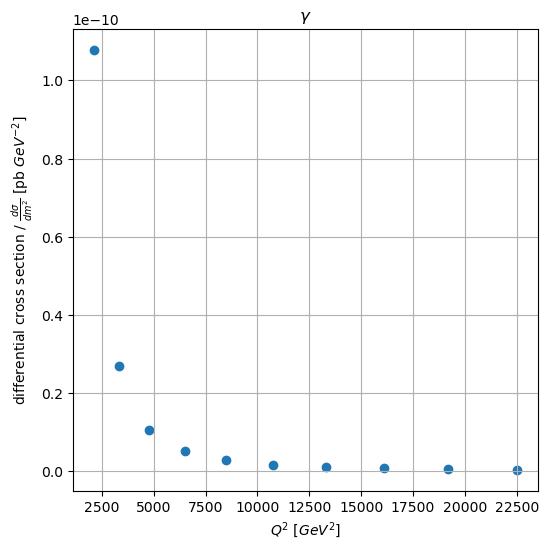

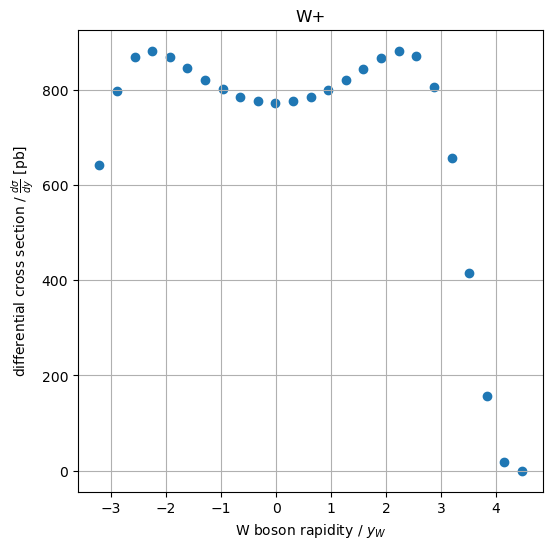

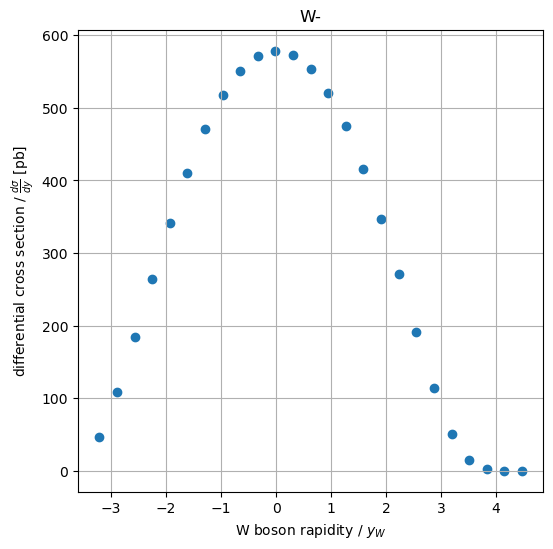

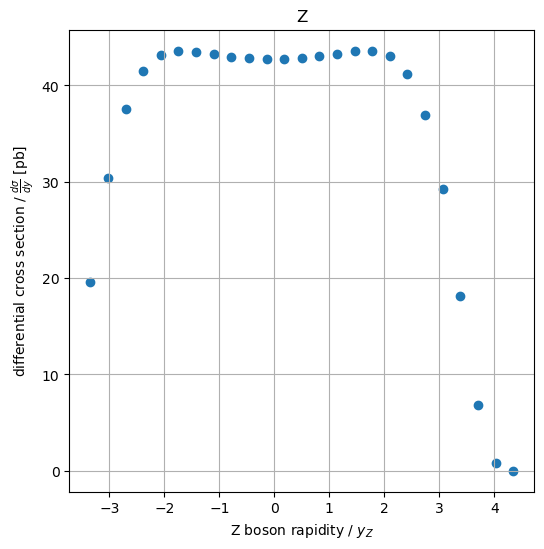


Cross-section aims.

Cross-section ratios.


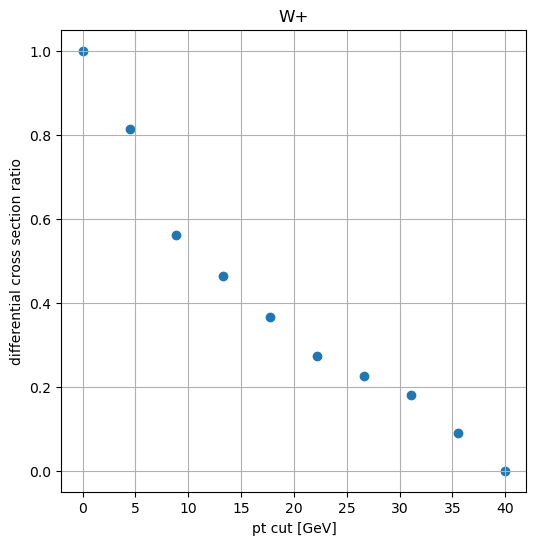

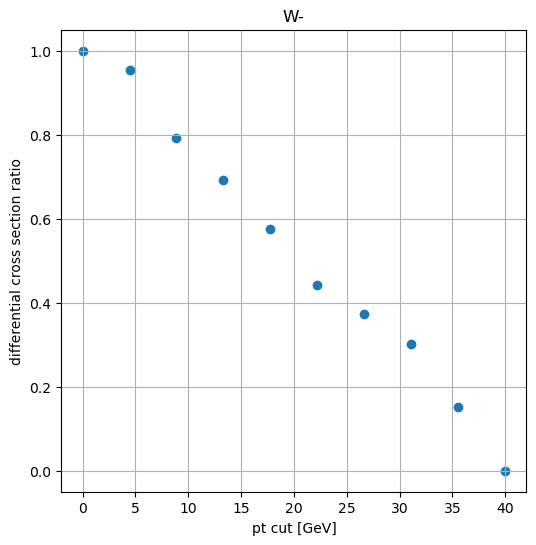

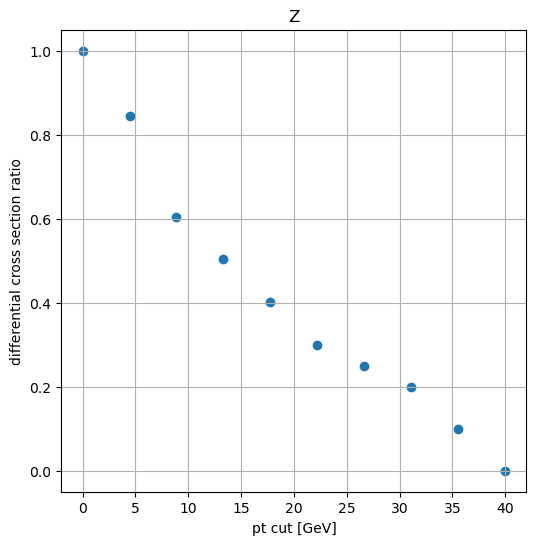


Integral visulisation.
+


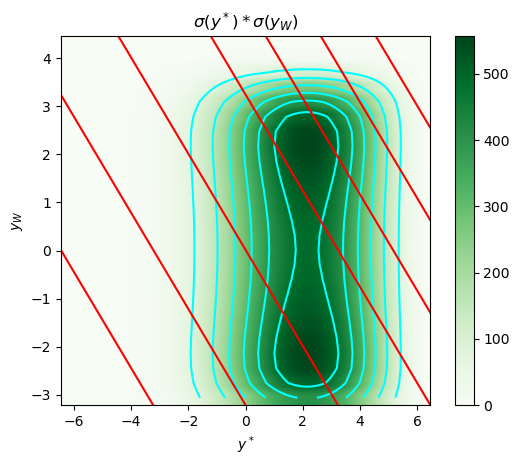

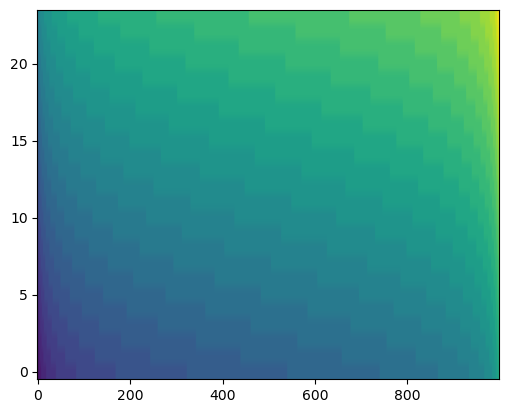

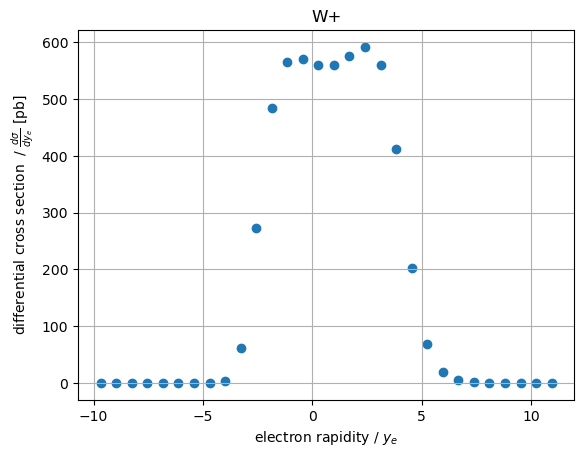

-


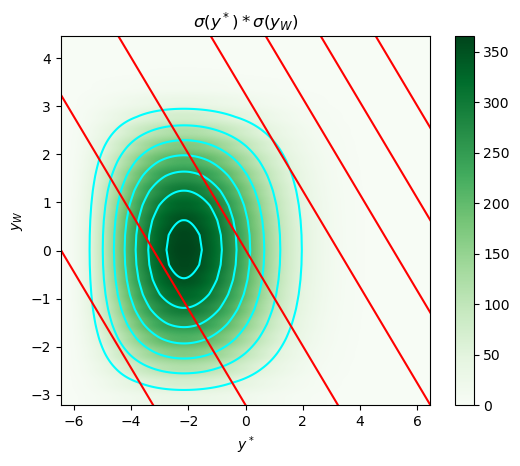

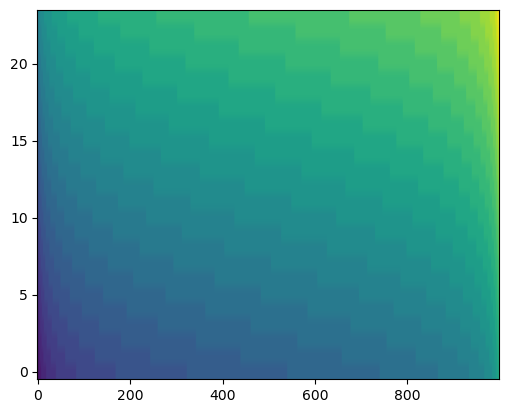

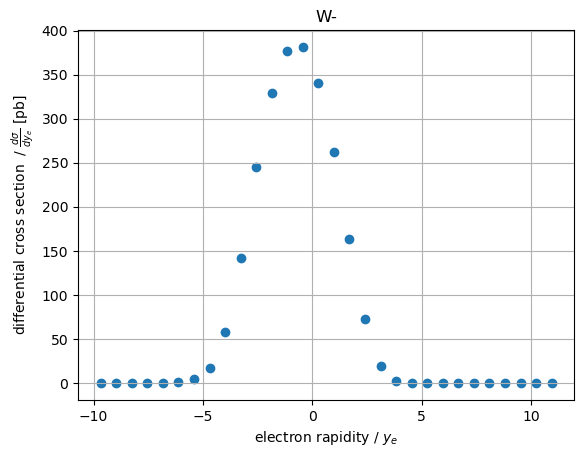

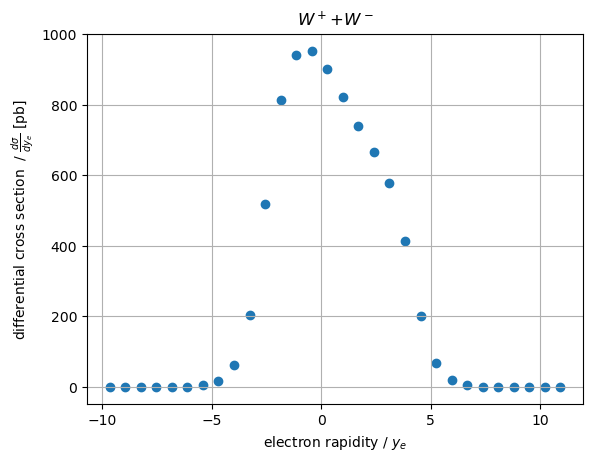

In [10]:
if __name__=='__main__':
    main()